In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import random
import pickle as pickle
import os
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()
# Step 4. 한글 글꼴 설정
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import  pprint
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict, Counter
from itertools import chain
from pprint import pprint
# from pycaret.classification import *
# from pycaret.regression import *
# from pycaret.utils import check_metric
from transformers import AutoTokenizer,AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoConfig
from transformers import BertConfig, BertForSequenceClassification, Trainer, TrainingArguments, BertModel, ElectraModel, RobertaModel
from importlib import import_module
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
def seed_everything(seed: int = 42, contain_cuda: bool = False):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"Seed set as {seed}")

seed=42
seed_everything(seed)

root_dir = "/content/drive/MyDrive/"
project_folder = "Phising"
os.chdir(os.path.join(root_dir,project_folder))


Seed set as 42


# Utils.py

In [7]:
from transformers.image_transforms import normalize
def wrong_batch_for_wandb(tokenizer,
                          wrong_sample_index,
                          input_ids,
                          valid_labels,
                          valid_predict,
                          valid_output,
                          ):
    num_to_label_dict = {0:'Normal',1:'Phising'}

    wrong_sample_index = np.where(valid_labels!=valid_predict)[0]
    wrong_sample_text = [tokenizer.decode(element, skip_special_tokens=False) for element in input_ids[wrong_sample_index]]
    wrong_sample_label = [num_to_label_dict[lab] for lab in list(valid_labels[wrong_sample_index])]
    wrong_sample_pred = [num_to_label_dict[pred] for pred in list(valid_predict[wrong_sample_index])]
    wrong_sample_output = valid_output[wrong_sample_index].tolist()

    normal_prob, phising_prob = [], []
    for element in wrong_sample_output:
        normal_prob.append(element[0])
        phising_prob.append(element[1])

    return wrong_sample_text, wrong_sample_label, wrong_sample_pred, normal_prob, phising_prob


# dataloader.py

In [8]:
def load_data(args, dataset_dir):
    print("===================loading data=====================")
    # load dataset
    dataset = pd.read_csv(dataset_dir)

    # print(dataset)

    return dataset

# bert input을 위한 tokenizing.
def tokenized_dataset(args, dataset, tokenizer):
  #전체 대화 데이터
    lst_comment = dataset['comment'].tolist()
  #키워드 + 형태소 데이터
    lst_pos = dataset['pos_keywords'].tolist()

    tokenized_sentences = tokenizer(
        lst_comment,
        lst_pos,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=args.seq_max_len,
        add_special_tokens=True
    )

    return tokenized_sentences

    all_dataset = load_data(args, dataset_dir = f'./data/{args.train_file}')

In [9]:
# Dataset 구성.
class NLI_Dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [10]:
def get_trainLoader(args, train_data, valid_data, train_label, valid_label, tokenizer):

    # entity_between = '</s></s>' if args.model == 'r_roberta' or args.model == 'roberta' else '[SEP]'
    tokenized_train = tokenized_dataset(args, train_data, tokenizer)
    tokenized_valid = tokenized_dataset(args, valid_data, tokenizer)

    # make dataset for pytorch.
    NLI_train_dataset = NLI_Dataset(tokenized_train, train_label)
    NLI_valid_dataset = NLI_Dataset(tokenized_valid, valid_label)

    trainloader = DataLoader(NLI_train_dataset,
                             batch_size=args.batch_size,
                             shuffle=True,
                             num_workers=args.num_workers,
                             )

    validloader = DataLoader(NLI_valid_dataset,
                             batch_size=args.batch_size,
                             shuffle=False,
                             num_workers=args.num_workers,
                             )

    return trainloader, validloader


# optimizer.py

In [11]:
from torch.optim import Adam, AdamW
from torch.optim.optimizer import Optimizer, required
import math

class AdamP(Optimizer):
    def __init__(
        self,
        params,
        lr=1e-3,
        betas=(0.9, 0.999),
        eps=1e-8,
        weight_decay=0,
        delta=0.1,
        wd_ratio=0.1,
        nesterov=False,
    ):
        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            delta=delta,
            wd_ratio=wd_ratio,
            nesterov=nesterov,
        )
        super(AdamP, self).__init__(params, defaults)

    def _channel_view(self, x):
        return x.view(x.size(0), -1)

    def _layer_view(self, x):
        return x.view(1, -1)

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        return F.cosine_similarity(x, y, dim=1, eps=eps).abs_()

    def _projection(self, p, grad, perturb, delta, wd_ratio, eps):
        wd = 1
        expand_size = [-1] + [1] * (len(p.shape) - 1)
        for view_func in [self._channel_view, self._layer_view]:

            cosine_sim = self._cosine_similarity(grad, p.data, eps, view_func)

            if cosine_sim.max() < delta / math.sqrt(view_func(p.data).size(1)):
                p_n = p.data / view_func(p.data).norm(dim=1).view(expand_size).add_(eps)
                perturb -= p_n * view_func(p_n * perturb).sum(dim=1).view(expand_size)
                wd = wd_ratio

                return perturb, wd

        return perturb, wd

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad.data
                beta1, beta2 = group["betas"]
                nesterov = group["nesterov"]

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p.data)
                    state["exp_avg_sq"] = torch.zeros_like(p.data)

                # Adam
                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]

                state["step"] += 1
                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(
                    group["eps"]
                )
                step_size = group["lr"] / bias_correction1

                if nesterov:
                    perturb = (beta1 * exp_avg + (1 - beta1) * grad) / denom
                else:
                    perturb = exp_avg / denom

                # Projection
                wd_ratio = 1
                if len(p.shape) > 1:
                    perturb, wd_ratio = self._projection(
                        p,
                        grad,
                        perturb,
                        group["delta"],
                        group["wd_ratio"],
                        group["eps"],
                    )

                # Weight decay
                if group["weight_decay"] > 0:
                    p.data.mul_(1 - group["lr"] * group["weight_decay"] * wd_ratio)

                # Step
                p.data.add_(perturb, alpha=-step_size)

        return loss

def get_optimizer(model, args):
    if args.optimizer == "Adam":
        optimizer = Adam(model.parameters(), lr=args.lr, weight_decay=0.01)
    elif args.optimizer == "AdamW":
        optimizer = AdamW(model.parameters(), lr=args.lr, weight_decay=0.01)
    elif args.optimizer == "AdamP":
        optimizer = AdamP(
            model.parameters(),
            lr=args.lr,
            betas=(0.9, 0.999),
            weight_decay=0.01,
            delta=0.1,
            wd_ratio=0.1,
            nesterov=False,
        )


    # 모든 parameter들의 grad값을 0으로 초기화
    optimizer.zero_grad()

    return optimizer


# scheduler.py

In [12]:
import math
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, _LRScheduler
from transformers import get_linear_schedule_with_warmup

# https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup/blob/master/cosine_annearing_with_warmup.py
class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """

    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps

        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle

        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle

        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)

        # set learning rate min_lr
        self.init_lr()

    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)

    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch

        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr


def get_scheduler(optimizer, args, total_batch_):
    if args.scheduler == "plateau":
        scheduler = ReduceLROnPlateau(
            optimizer, patience=2, factor=0.85, mode="max", verbose=True
        )
    elif args.scheduler == "linear":
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            # num_warmup_steps=int(total_batch_*args.epochs*0.1),
            num_warmup_steps=args.warmup_steps,
            num_training_steps=int(total_batch_*args.epochs),
        )
    elif args.scheduler == "cosine":
        scheduler = CosineAnnealingWarmupRestarts( # ver1: first_cycle=20, warmup_steps=5, cycle_mult=1.0, max_lr=args.lr, min_lr=args.lr/100, gamma=0.8, patience=7,
            optimizer,                             # ver2: first_cycle=30, warmup_steps=5, cycle_mult=0.8, max_lr=args.lr, min_lr=args.lr/100, gamma=0.8, patience=5
            first_cycle_steps=300,                  # ver3: first_cycle=50, warmup_steps=10, cycle_mult=1.0, max_lr=args.lr, min_lr=args.lr/100, gamma=0.8, patience=7
            warmup_steps=args.warmup_steps,
            cycle_mult=args.cycle_mult,
            max_lr=args.lr,
            min_lr=args.lr * 0.01,
            gamma=0.8,
        )

    return scheduler



# model.py

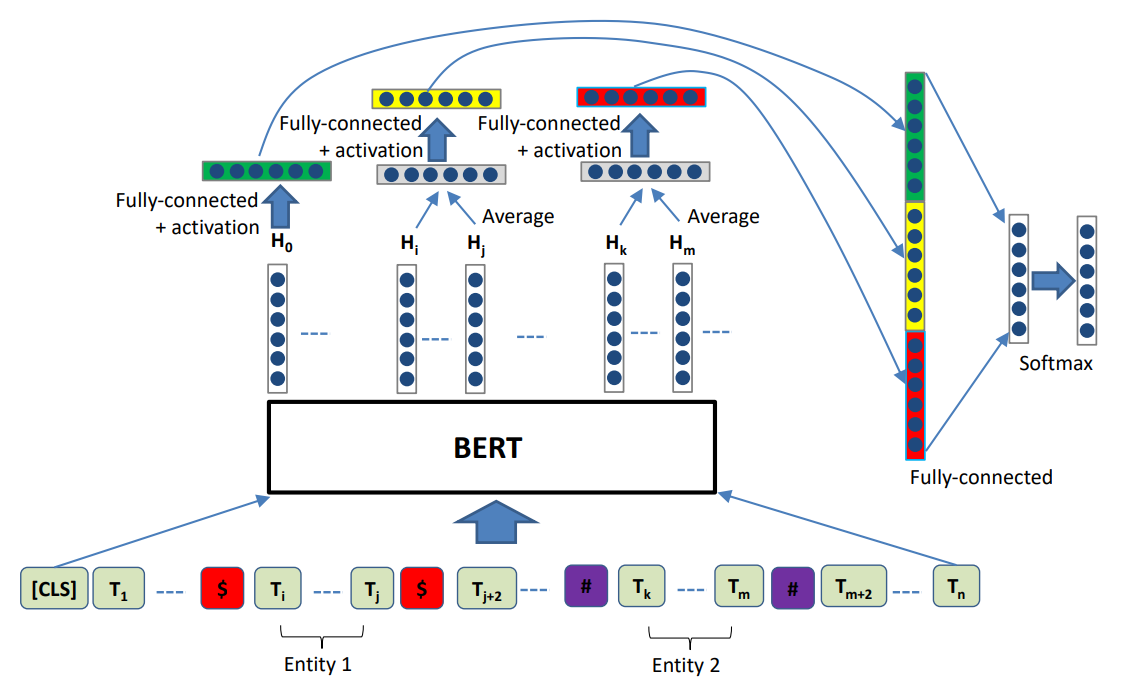

- R-BERT 모델로부터 아이디어를 얻어 KoBIGBIRD 모델의 아키텍쳐를 수정
- Relation Extraction Task에서 R-BERT 모델은 CLS 토큰 뿐만 아니라 entity1과 entity2 임베딩 벡터를 같이 활용함으로써 그 성능을 높이고자함
- CLS 토큰뿐만 아니라 comment와 pos(or keywords) 각각의 임베딩 벡터를 학습에 사용하는 것은 어떨까? 라는 관점에서 Custom된 모델

In [13]:
model_path = "monologg/kobigbird-bert-base"
config=AutoConfig.from_pretrained(model_path)

##attention type
#config.attention_type = "original_full"
print(config)

BigBirdConfig {
  "_name_or_path": "monologg/kobigbird-bert-base",
  "architectures": [
    "BigBirdForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "attention_type": "block_sparse",
  "block_size": 64,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "gradient_checkpointing": false,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 4096,
  "model_type": "big_bird",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_random_blocks": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "rescale_embeddings": false,
  "sep_token_id": 3,
  "tokenizer_class": "BertTokenizer",
  "torch_dtype": "float32",
  "transformers_version": "4.32.1",
  "type_vocab_size": 2,
  "use_bias": true,
  "use_cache": true,
  "vocab_size": 32500
}



In [14]:
#path=klue/roberta-large
tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base")
tokenizer(['l like you'],['l hate you'])


{'input_ids': [[2, 580, 19667, 16625, 3, 580, 17357, 15224, 16625, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [15]:
# Relation Extraction R-BERT 아이디어 차용
# https://github.com/monologg/R-BERT/blob/master/model.py#L21
class r_kobigbird_Classifier(nn.Module):
    def __init__(self, kobigbird, hidden_size=768, num_classes=2, dr_rate=0.0):

        super(r_kobigbird_Classifier, self).__init__()


        self.kobigbird = kobigbird
        self.dr_rate = dr_rate

        self.cls_fc = FCLayer(hidden_size, hidden_size//2, self.dr_rate)
        self.sentence_fc = FCLayer(hidden_size, hidden_size//2, self.dr_rate)
        self.label_classifier = FCLayer(hidden_size//2 * 3, num_classes, self.dr_rate, False)

    def forward(self, token_ids, attention_mask, segment_ids=None):
        out = self.kobigbird(input_ids=token_ids, attention_mask=attention_mask)[0]

        #KoBIGBIRD에서는 token_ids==3 : 문장의 끝을 나타냄
        #따라서 두 문장을 동시에 넣었으므로, 문장의 끝을 나타내는 인덱스의 위치를 찾아내서 구분
        sentence_end_position = torch.where(token_ids == 3)[1] # input_ids==3인 인덱스를 찾음
        sent1_end, sent2_end = sentence_end_position[0], sentence_end_position[1]

        cls_vector = out[:, 0, :] # take <s> token (equiv. to [CLS])
        comment_vector = out[:,1:sent1_end]              # Get comment vector
        poskeywords_vector = out[:,sent1_end+1:sent2_end]    # Get poskeywords vector

        comment_vector = torch.mean(comment_vector, dim=1) # Average
        poskeywords_vector = torch.mean(poskeywords_vector, dim=1)


        # Dropout -> tanh -> fc_layer (Share FC layer for comment and pos)
        cls_embedding = self.cls_fc(cls_vector)
        comment_embedding = self.sentence_fc(comment_vector)
        poskeywords_embedding = self.sentence_fc(poskeywords_vector)

        # Concat -> fc_layer
        concat_embedding = torch.cat([cls_embedding, comment_embedding, poskeywords_embedding], dim=-1)

        return self.label_classifier(concat_embedding)


class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.0, use_activation=True):
        super(FCLayer, self).__init__()
        self.use_activation = use_activation
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(input_dim, output_dim)
        self.tanh = nn.Tanh()

        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, x):
        x = self.dropout(x)
        if self.use_activation:
            x = self.tanh(x)
        return self.linear(x)

In [16]:
def get_tokenizer(args):

  if args.model == 'klue_roberta_large':
    tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

  elif args.model == 'r_kobigbird':
    tokenizer = AutoTokenizer.from_pretrained("monologg/kobigbird-bert-base")

  else:
    raise NotImplementedError('Tokenizer & Model not available')

  return tokenizer


In [17]:
def get_model(args):

  if args.model == 'klue_roberta_large': #1024
    feature_model = RobertaModel.from_pretrained("klue/roberta-large", add_pooling_layer=False)
    #model = roberta_large_Classifier(feature_model, dr_rate=args.dp)

  elif args.model == 'r_kobigbird':
    feature_model = AutoModel.from_pretrained("monologg/kobigbird-bert-base",config=config, add_pooling_layer=False)
    model = r_kobigbird_Classifier(feature_model, dr_rate=args.dp)

  else:
    raise NotImplementedError('Tokenizer & Model not available')

  return model


# loss.py

In [18]:
# https://discuss.pytorch.org/t/is-this-a-correct-implementation-for-focal-loss-in-pytorch/43327/8
class FocalLoss(nn.Module):
    def __init__(self, weight=None,
                 gamma=2., reduction='mean'):
        nn.Module.__init__(self)
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input_tensor, target_tensor):
        log_prob = F.log_softmax(input_tensor, dim=-1)
        prob = torch.exp(log_prob)
        return F.nll_loss(
            ((1 - prob) ** self.gamma) * log_prob,
            target_tensor,
            weight=self.weight,
            reduction=self.reduction
        )

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes=2, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


def get_criterion(args):
    if args.smoothing!=0 and args.criterion == 'smoothing':
        criterion = LabelSmoothingLoss(smoothing=args.smoothing)
    elif args.criterion == 'cross':
        criterion = nn.CrossEntropyLoss()
    elif args.criterion == 'focal':
        criterion = FocalLoss(gamma=2.0)
    else:
        raise NotImplementedError('Criterion not available')
    return criterion

# train.py

In [19]:
def Train(args, fold_lst=[4,5]):
    criterion = get_criterion(args)
    tokenizer = get_tokenizer(args)
    all_dataset = load_data(args, dataset_dir = f'./data/{args.train_file}')
    all_label = all_dataset['label'].values

    kf = StratifiedKFold(n_splits=args.n_splits, random_state=42, shuffle=True)
    fold_idx = 1
    best_val_acc_list = []
    for train_index, test_index in kf.split(all_dataset, all_label):
        if fold_idx not in fold_lst:
            fold_idx+=1
            continue

        os.makedirs(f'./models/{args.model_name}/{fold_idx}-fold', exist_ok=True)
        ### Model Select
        model = get_model(args)
        print('===================get model===================')
        model.to(device)


        train_data, valid_data = all_dataset.iloc[train_index], all_dataset.iloc[test_index]
        train_label, valid_label = all_label[train_index], all_label[test_index]

        print(f"len(train_label) : {len(train_label)}")
        print(f"len(train_data) : {len(train_data)}")


        trainloader, validloader = get_trainLoader(args, train_data, valid_data, train_label, valid_label, tokenizer)

        print('get train & valid loader')

        total_batch_ = len(trainloader)
        valid_batch_ = len(validloader)



        ### Optimizer
        optimizer = get_optimizer(model, args)

        ### Scheduler
        scheduler = get_scheduler(optimizer, args, total_batch_)

        print('get optimzer & scheduler')

        best_val_loss, best_val_acc, = np.inf, 0
        early_stopping_counter = 0

        print(f"---------------------------------- {fold_idx} fold----------------------------------")
        for i in tqdm(range(1, args.epochs+1)):
            model.train()
            epoch_perform, batch_perform = np.zeros(2), np.zeros(2)
            print()
            progress_bar = tqdm(enumerate(trainloader), total=len(trainloader), leave=True, position=0,)
            for j, v in progress_bar:
                input_ids, attention_mask, labels = v['input_ids'].to(device), v['attention_mask'].to(device), v['labels'].to(device)

                if 'roberta' in args.model:
                    token_type_ids = None
                else:
                    token_type_ids = v['token_type_ids'].to(device)
                optimizer.zero_grad()

                output = model(input_ids, attention_mask, token_type_ids) ## label을 안 넣어서 logits값만 출력

                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()


                predict = output.argmax(dim=-1)
                predict = predict.detach().cpu().numpy()
                labels = labels.detach().cpu().numpy()

                #평가지표 : f1_score >> 분류 문제에서는 accuracy보다는 f1_score
                acc = f1_score(labels, predict,average='weighted')

                batch_perform += np.array([loss.item(), acc])
                epoch_perform += np.array([loss.item(), acc])

                if (j + 1) % 50 == 0:
                    print(
                        f"Epoch {i:#04d} #{j + 1:#03d} -- loss: {batch_perform[0] / 50:#.5f}, acc: {batch_perform[1] / 50:#.4f}"
                        )
                    batch_perform = np.zeros(2)
            print()
            print(
                f"Epoch {i:#04d} loss: {epoch_perform[0] / total_batch_:#.5f}, acc: {epoch_perform[1] / total_batch_:#.2f}"
                )

            ###### Validation
            model.eval()
            valid_perform = np.zeros(2)

            all_valid_predict_lst = []
            all_valid_labels_lst = []



            with torch.no_grad():
                for v in validloader:
                    input_ids, attention_mask, valid_labels = v['input_ids'].to(device), v['attention_mask'].to(device), v['labels'].to(device)

                    if 'roberta' in args.model:
                        token_type_ids = None
                    else:
                        token_type_ids = v['token_type_ids'].to(device)

                    valid_output = model(input_ids, attention_mask, token_type_ids)
                    valid_loss = criterion(valid_output, valid_labels)

                    valid_predict = valid_output.argmax(dim=-1)
                    valid_predict = valid_predict.detach().cpu().numpy()
                    valid_labels = valid_labels.detach().cpu().numpy()


                    valid_acc = f1_score(valid_labels, valid_predict,average='weighted')
                    valid_perform += np.array([valid_loss.item(), valid_acc])

                    all_valid_predict_lst += list(valid_predict)
                    all_valid_labels_lst += list(valid_labels)

            ###### Model save
            val_total_loss = valid_perform[0] / valid_batch_
            val_total_acc = valid_perform[1] / valid_batch_
            best_val_loss = min(best_val_loss, val_total_loss)

            if val_total_acc > best_val_acc:    #  and val_total_acc >= 0.25
                print(f"New best model for val accuracy : {val_total_acc:#.4f}! saving the best model..")
                torch.save(model.state_dict(), f"./models/{args.model_name}/{fold_idx}-fold/best.pt")

                # 참고 : Model 추가 재학습을 위한 모델을 저장하는 코드
                # https://tutorials.pytorch.kr/beginner/saving_loading_models.html#checkpoint

                best_val_acc = val_total_acc
                early_stopping_counter = 0


            else: # best보다 score가 안 좋을 때, early stopping check
                early_stopping_counter += 1
                if early_stopping_counter >= args.patience:
                    print(
                        f"EarlyStopping counter: {early_stopping_counter} out of {args.patience}"
                    )
                    break

            print()
            print(
                f">>>> Validation loss: {val_total_loss:#.5f}, Acc: {val_total_acc:#.4f}"
                )

        best_val_acc_list.append(best_val_acc)

        fold_idx +=1
    print('='*50)
    print(f"{args.n_splits}-fold best_val_acc_list : {best_val_acc_list}")
    print('='*15, f'{args.n_splits}-fold Final Score(ACC) : {np.mean(best_val_acc_list)}', '='*15)

In [20]:
#형태소 및 키워드 데이터 불러오기
df=pd.read_csv("FinalData_with_pos_keywords.csv")
#df=df.sample(7700)
df['label'].value_counts()

1    12067
0    11473
Name: label, dtype: int64

In [21]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df, test_size=0.2, random_state=42)

train['label'].value_counts()

1    9647
0    9185
Name: label, dtype: int64

In [22]:
train['pos_keywords']=train['pos']+train['keywords']
test['pos_keywords']=test['pos']+test['keywords']

train=train[['comment','pos','keywords','pos_keywords','label']]
test=test[['comment','pos','keywords','pos_keywords','label']]

train.head()

,comment,pos,keywords,pos_keywords,label
3,네. 대출금 추정 후 연체가 없으면 원리 균등분할상환 원금 이상 중 한 번 상법을 ...,출금 추정 연체 없다 원리 균등 분할 상환 원금 이상 하다 상법 변경 하다 있다 ...,"상환, 다음, 수도, 계약, 공사, 설정, 방법, 자동, 대출, 캠코, 대해, 스포...",출금 추정 연체 없다 원리 균등 분할 상환 원금 이상 하다 상법 변경 하다 있다 ...,1
12250,기업은행입니다. 무엇을 도와 드릴까요 고객님? 수표를 분실했습니다. 어떻게 해야 하...,기업은행 이다 무엇 드릴 끄다 고객 수표 분실 하다 어떻다 하다 하나요 가깝다 영...,"신고, 사고, 방문, 서면, 영업, 수표, 문의사항, 가능성, 해제, 남편, 하나요...",기업은행 이다 무엇 드릴 끄다 고객 수표 분실 하다 어떻다 하다 하나요 가깝다 영...,0
14720,적금통장 해지하려고 요 적금 만기가 안 됐는데 해지가 되나요? 되기는 합니다만 손해...,적금 통장 해지 하다 적금 만기 돼다 해지 되다 되다 기다 하다 손해 발생 되다 ...,"해지, 만기, 적금, 얼마, 손해, 뭔가, 복구, 생각, 원금, 사유, 발생, 언제...",적금 통장 해지 하다 적금 만기 돼다 해지 되다 되다 기다 하다 손해 발생 되다 ...,0
17134,보험계약대출을 받으려고 하는데 인터넷을 신청이 가능한가요? 네. 가능합니다. 고객님...,보험 대출 받다 하다 인터넷 신청 가능하다 가능하다 고객 인터넷 대출 신청 하다 ...,"통장, 입금, 대출, 고객, 보험, 때문, 혹시, 명의, 오늘, 확인, 정도, 시간...",보험 대출 받다 하다 인터넷 신청 가능하다 가능하다 고객 인터넷 대출 신청 하다 ...,0
7898,"그랬고요 제가 몇 가지 질문 좀 드리고 바로 본론 말씀드리겠습니다. 네, 본인 혹시...",그렇다 가지 질문 드리다 바로 본론 말씀드리다 본인 혹시 거주 하다 사다 남성 김...,"지금, 녹음, 저희, 질문, 바로, 매우, 가지, 범죄수사, 거주, 직업, 첨단, ...",그렇다 가지 질문 드리다 바로 본론 말씀드리다 본인 혹시 거주 하다 사다 남성 김...,1


In [23]:
train.to_csv('./data/train_data.csv',index=False)
test.to_csv('./data/test_data.csv',index=False)
test.head()

,comment,pos,keywords,pos_keywords,label
5945,해요. 일단 잘 알겠고요 저희들이 금융 계열사 저축은행인데요 지금 오월에 저희들이 ...,일단 자다 알다 저희 금융 열사 저축은행 지금 오월 저희 대화 대출 플러스 생활 ...,"대출, 오월, 저희, 일단, 지금, 이름, 오천만, 생활, 전화, 자금, 프로, 삼...",일단 자다 알다 저희 금융 열사 저축은행 지금 오월 저희 대화 대출 플러스 생활 ...,1
1288,"똑바로 얘기하라고 야, 신고하면 진짜 죽 여버린 다 여보 세 그러니까요? 나는 돈이...",똑바로 얘기 신고 하다 진짜 버리다 여보 필요하다 혜림이 잠깐 데리 있다 거지 사...,"사람, 전화, 똑바로, 혜림이, 신고, 잠깐, 지금, 얘기, 거지, 여보, 데리, 진짜",똑바로 얘기 신고 하다 진짜 버리다 여보 필요하다 혜림이 잠깐 데리 있다 거지 사...,1
17581,중학교 1학년 자녀의 펀드 계좌를 만들고 싶은데요? 계좌 개설 가능하십니다. 영업점...,중학교 학년 자녀 펀드 계좌 만들다 싶다 계좌 개설 가능하다 영업 가지 않다 개설...,"개설, 영업, 부모님, 서류, 학년, 방문, 가족, 문자, 증명서, 신분증, 혼자,...",중학교 학년 자녀 펀드 계좌 만들다 싶다 계좌 개설 가능하다 영업 가지 않다 개설...,0
8086,여보세요 어떤 부분으로요? 지금 제가 황이 연사 건의 황민 씨 사건에 연루돼 있기 ...,어떻다 부분 지금 연사 건의 황민 사건 연루 돼다 있다 때문 저희 검찰청 오다 조...,"일정, 저희, 연락, 시간, 처음, 세탁, 지금, 사건, 통장, 질문, 수사, 때문...",어떻다 부분 지금 연사 건의 황민 사건 연루 돼다 있다 때문 저희 검찰청 오다 조...,1
7615,여보세요 드립니다. 제가 하셔야 되기 때문에 이 부분을 옛날 드리고 통화가 안 하시...,드리다 하다 되다 때문 부분 옛날 드리다 통화 하다 지금 부분 대해 조사 높이 하...,"저희, 지금, 본인, 삼월, 대부분, 강남구, 결과, 고요, 동결, 수사, 가끔, ...",드리다 하다 되다 때문 부분 옛날 드리다 통화 하다 지금 부분 대해 조사 높이 하...,1


In [24]:
import easydict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'current device : {device}')

args = easydict.EasyDict({
        "seed":42,
        "optimizer":"AdamW",    # help = (AdamW, Adam, AdamP)
        "scheduler":"linear",     # help= (linear, cosine, plateau ...)
        "warmup_steps":500,
        "cycle_mult":1.2,
        "seq_max_len":750, # For using block_sparse(attention type),it muse be longer than 704
        "batch_size": 8, #16
        "epochs": 20,
        "patience":5,
        "n_splits" : 5,
        "lr": 1e-05,
        "num_workers":2,
        "criterion":'cross', # 'smoothing','focal','cross'
        "smoothing": 0.0,
        "dp": 0.0,
        "model": "r_kobigbird",  # help='model type ( r_kobigbird, r_klue_roberta)'

        "logging_wrong_samples":False,
        "train_file":'train_data.csv',
        "test_file":'test_data.csv',
        "add_klue_data":False,
        'add_nikl_data':False,
    })

project_name = f"[comment+(pos+keywords)]_{args.model}_Scdu{args.scheduler}_Dp{args.dp}_add_klue_data{args.add_klue_data}_{args.n_splits}Fd_Sm{args.smoothing}_Bs{args.batch_size}_Lr{args.lr}_Ep{args.epochs}_Cy{args.cycle_mult}"
args.update(
            {
                "project_name":project_name,
                "model_name":project_name,
             }
            )

seed_everything(args.seed)


current device : cpu
Seed set as 42


In [25]:
args

{'seed': 42,
 'optimizer': 'AdamW',
 'scheduler': 'linear',
 'warmup_steps': 500,
 'cycle_mult': 1.2,
 'seq_max_len': 750,
 'batch_size': 8,
 'epochs': 20,
 'patience': 5,
 'n_splits': 5,
 'lr': 1e-05,
 'num_workers': 2,
 'criterion': 'cross',
 'smoothing': 0.0,
 'dp': 0.0,
 'model': 'r_kobigbird',
 'logging_wrong_samples': False,
 'train_file': 'train_data.csv',
 'test_file': 'test_data.csv',
 'add_klue_data': False,
 'add_nikl_data': False,
 'project_name': '[comment+(pos+keywords)]_r_kobigbird_Scdulinear_Dp0.0_add_klue_dataFalse_5Fd_Sm0.0_Bs8_Lr1e-05_Ep20_Cy1.2',
 'model_name': '[comment+(pos+keywords)]_r_kobigbird_Scdulinear_Dp0.0_add_klue_dataFalse_5Fd_Sm0.0_Bs8_Lr1e-05_Ep20_Cy1.2'}

## Training

- 모델 학습에서 5-Fold Ensemble을 시도했지만, Colab의 Ram부족,,GPU부족..ㅠ 이슈로 인하여 fold 1번 이외 학습 불가

In [48]:
Train(args, fold_lst=[4])

===================loading data=====================


===================get model===================
len(train_label) : 15066
len(train_data) : 15066
get train & valid loader
get optimzer & scheduler
---------------------------------- 4 fold----------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

  3%|▎         | 50/1884 [01:46<1:03:39,  2.08s/it]

Epoch 0001 #050 -- loss: 0.72387, acc: 0.4191


  5%|▌         | 100/1884 [03:30<1:02:04,  2.09s/it]

Epoch 0001 #100 -- loss: 0.56752, acc: 0.7607


  8%|▊         | 150/1884 [05:14<1:00:15,  2.08s/it]

Epoch 0001 #150 -- loss: 0.32978, acc: 0.9408


 11%|█         | 200/1884 [06:58<58:16,  2.08s/it]

Epoch 0001 #200 -- loss: 0.10517, acc: 0.9746


 13%|█▎        | 250/1884 [08:42<56:47,  2.09s/it]

Epoch 0001 #250 -- loss: 0.03903, acc: 0.9900


 16%|█▌        | 300/1884 [10:26<54:58,  2.08s/it]

Epoch 0001 #300 -- loss: 0.02656, acc: 0.9949


 19%|█▊        | 350/1884 [12:11<53:08,  2.08s/it]

Epoch 0001 #350 -- loss: 0.02105, acc: 0.9923


 21%|██        | 400/1884 [13:55<51:31,  2.08s/it]

Epoch 0001 #400 -- loss: 0.03012, acc: 0.9854


 24%|██▍       | 450/1884 [15:39<49:44,  2.08s/it]

Epoch 0001 #450 -- loss: 0.00882, acc: 0.9974


 27%|██▋       | 500/1884 [17:23<48:00,  2.08s/it]

Epoch 0001 #500 -- loss: 0.00837, acc: 0.9972


 29%|██▉       | 550/1884 [19:07<46:07,  2.07s/it]

Epoch 0001 #550 -- loss: 0.03918, acc: 0.9922


 32%|███▏      | 600/1884 [20:51<44:34,  2.08s/it]

Epoch 0001 #600 -- loss: 0.01629, acc: 0.9974


 35%|███▍      | 650/1884 [22:35<42:51,  2.08s/it]

Epoch 0001 #650 -- loss: 0.00295, acc: 1.0000


 37%|███▋      | 700/1884 [24:19<41:07,  2.08s/it]

Epoch 0001 #700 -- loss: 0.00733, acc: 0.9952


 40%|███▉      | 750/1884 [26:03<39:23,  2.08s/it]

Epoch 0001 #750 -- loss: 0.04496, acc: 0.9803


 42%|████▏     | 800/1884 [27:47<37:36,  2.08s/it]

Epoch 0001 #800 -- loss: 0.01132, acc: 0.9975


 45%|████▌     | 850/1884 [29:31<35:57,  2.09s/it]

Epoch 0001 #850 -- loss: 0.00344, acc: 1.0000


 48%|████▊     | 900/1884 [31:16<34:07,  2.08s/it]

Epoch 0001 #900 -- loss: 0.00161, acc: 1.0000


 50%|█████     | 950/1884 [33:00<32:19,  2.08s/it]

Epoch 0001 #950 -- loss: 0.00076, acc: 1.0000


 53%|█████▎    | 1000/1884 [34:44<30:37,  2.08s/it]

Epoch 0001 #1000 -- loss: 0.00327, acc: 1.0000


 56%|█████▌    | 1050/1884 [36:28<28:52,  2.08s/it]

Epoch 0001 #1050 -- loss: 0.00025, acc: 1.0000


 58%|█████▊    | 1100/1884 [38:12<27:07,  2.08s/it]

Epoch 0001 #1100 -- loss: 0.00082, acc: 1.0000


 61%|██████    | 1150/1884 [39:56<25:25,  2.08s/it]

Epoch 0001 #1150 -- loss: 0.00159, acc: 1.0000


 64%|██████▎   | 1200/1884 [41:40<23:40,  2.08s/it]

Epoch 0001 #1200 -- loss: 0.00014, acc: 1.0000


 66%|██████▋   | 1250/1884 [43:24<22:00,  2.08s/it]

Epoch 0001 #1250 -- loss: 0.01182, acc: 0.9950


 69%|██████▉   | 1300/1884 [45:08<20:13,  2.08s/it]

Epoch 0001 #1300 -- loss: 0.00139, acc: 1.0000


 72%|███████▏  | 1350/1884 [46:52<18:28,  2.08s/it]

Epoch 0001 #1350 -- loss: 0.00038, acc: 1.0000


 74%|███████▍  | 1400/1884 [48:36<16:49,  2.09s/it]

Epoch 0001 #1400 -- loss: 0.00022, acc: 1.0000


 77%|███████▋  | 1450/1884 [50:20<15:02,  2.08s/it]

Epoch 0001 #1450 -- loss: 0.00014, acc: 1.0000


 80%|███████▉  | 1500/1884 [52:04<13:18,  2.08s/it]

Epoch 0001 #1500 -- loss: 0.00022, acc: 1.0000


 82%|████████▏ | 1550/1884 [53:48<11:37,  2.09s/it]

Epoch 0001 #1550 -- loss: 0.00008, acc: 1.0000


 85%|████████▍ | 1600/1884 [55:32<09:49,  2.08s/it]

Epoch 0001 #1600 -- loss: 0.00057, acc: 1.0000


 88%|████████▊ | 1650/1884 [57:16<08:07,  2.08s/it]

Epoch 0001 #1650 -- loss: 0.00025, acc: 1.0000


 90%|█████████ | 1700/1884 [59:00<06:22,  2.08s/it]

Epoch 0001 #1700 -- loss: 0.00020, acc: 1.0000


 93%|█████████▎| 1750/1884 [1:00:44<04:38,  2.08s/it]

Epoch 0001 #1750 -- loss: 0.00017, acc: 1.0000


 96%|█████████▌| 1800/1884 [1:02:28<02:55,  2.09s/it]

Epoch 0001 #1800 -- loss: 0.00051, acc: 1.0000


 98%|█████████▊| 1850/1884 [1:04:13<01:10,  2.09s/it]

Epoch 0001 #1850 -- loss: 0.00037, acc: 1.0000


100%|██████████| 1884/1884 [1:05:22<00:00,  2.08s/it]


Epoch 0001 loss: 0.05462, acc: 0.97


New best model for val accuracy : 0.9990! saving the best model..


  5%|▌         | 1/20 [1:09:41<22:04:00, 4181.10s/it]


>>>> Validation loss: 0.01106, Acc: 0.9990



  3%|▎         | 50/1884 [01:44<1:03:45,  2.09s/it]

Epoch 0002 #050 -- loss: 0.00474, acc: 1.0000


  5%|▌         | 100/1884 [03:28<1:01:51,  2.08s/it]

Epoch 0002 #100 -- loss: 0.00054, acc: 1.0000


  8%|▊         | 150/1884 [05:12<1:00:03,  2.08s/it]

Epoch 0002 #150 -- loss: 0.00070, acc: 1.0000


 11%|█         | 200/1884 [06:56<58:35,  2.09s/it]

Epoch 0002 #200 -- loss: 0.00081, acc: 1.0000


 13%|█▎        | 250/1884 [08:40<56:39,  2.08s/it]

Epoch 0002 #250 -- loss: 0.00080, acc: 1.0000


 16%|█▌        | 300/1884 [10:24<54:59,  2.08s/it]

Epoch 0002 #300 -- loss: 0.00036, acc: 1.0000


 19%|█▊        | 350/1884 [12:08<53:06,  2.08s/it]

Epoch 0002 #350 -- loss: 0.00017, acc: 1.0000


 21%|██        | 400/1884 [13:53<51:34,  2.09s/it]

Epoch 0002 #400 -- loss: 0.00015, acc: 1.0000


 24%|██▍       | 450/1884 [15:36<49:43,  2.08s/it]

Epoch 0002 #450 -- loss: 0.00030, acc: 1.0000


 27%|██▋       | 500/1884 [17:21<48:03,  2.08s/it]

Epoch 0002 #500 -- loss: 0.00350, acc: 0.9974


 29%|██▉       | 550/1884 [19:04<46:06,  2.07s/it]

Epoch 0002 #550 -- loss: 0.00048, acc: 1.0000


 32%|███▏      | 600/1884 [20:49<44:29,  2.08s/it]

Epoch 0002 #600 -- loss: 0.00006, acc: 1.0000


 35%|███▍      | 650/1884 [22:33<42:52,  2.08s/it]

Epoch 0002 #650 -- loss: 0.00044, acc: 1.0000


 37%|███▋      | 700/1884 [24:17<41:10,  2.09s/it]

Epoch 0002 #700 -- loss: 0.03547, acc: 0.9900


 40%|███▉      | 750/1884 [26:01<39:16,  2.08s/it]

Epoch 0002 #750 -- loss: 0.00373, acc: 0.9975


 42%|████▏     | 800/1884 [27:45<37:33,  2.08s/it]

Epoch 0002 #800 -- loss: 0.00785, acc: 0.9952


 45%|████▌     | 850/1884 [29:29<35:55,  2.08s/it]

Epoch 0002 #850 -- loss: 0.00138, acc: 1.0000


 48%|████▊     | 900/1884 [31:13<34:01,  2.07s/it]

Epoch 0002 #900 -- loss: 0.00007, acc: 1.0000


 50%|█████     | 950/1884 [32:57<32:22,  2.08s/it]

Epoch 0002 #950 -- loss: 0.00006, acc: 1.0000


 53%|█████▎    | 1000/1884 [34:41<30:38,  2.08s/it]

Epoch 0002 #1000 -- loss: 0.00333, acc: 0.9975


 56%|█████▌    | 1050/1884 [36:25<28:57,  2.08s/it]

Epoch 0002 #1050 -- loss: 0.00070, acc: 1.0000


 58%|█████▊    | 1100/1884 [38:09<27:11,  2.08s/it]

Epoch 0002 #1100 -- loss: 0.00008, acc: 1.0000


 61%|██████    | 1150/1884 [39:53<25:27,  2.08s/it]

Epoch 0002 #1150 -- loss: 0.00009, acc: 1.0000


 64%|██████▎   | 1200/1884 [41:37<23:47,  2.09s/it]

Epoch 0002 #1200 -- loss: 0.00007, acc: 1.0000


 66%|██████▋   | 1250/1884 [43:21<21:53,  2.07s/it]

Epoch 0002 #1250 -- loss: 0.00014, acc: 1.0000


 69%|██████▉   | 1300/1884 [45:05<20:13,  2.08s/it]

Epoch 0002 #1300 -- loss: 0.00006, acc: 1.0000


 72%|███████▏  | 1350/1884 [46:49<18:29,  2.08s/it]

Epoch 0002 #1350 -- loss: 0.00006, acc: 1.0000


 74%|███████▍  | 1400/1884 [48:33<16:46,  2.08s/it]

Epoch 0002 #1400 -- loss: 0.00007, acc: 1.0000


 77%|███████▋  | 1450/1884 [50:17<15:00,  2.08s/it]

Epoch 0002 #1450 -- loss: 0.00005, acc: 1.0000


 80%|███████▉  | 1500/1884 [52:01<13:19,  2.08s/it]

Epoch 0002 #1500 -- loss: 0.00004, acc: 1.0000


 82%|████████▏ | 1550/1884 [53:45<11:33,  2.08s/it]

Epoch 0002 #1550 -- loss: 0.00005, acc: 1.0000


 85%|████████▍ | 1600/1884 [55:29<09:50,  2.08s/it]

Epoch 0002 #1600 -- loss: 0.00004, acc: 1.0000


 88%|████████▊ | 1650/1884 [57:13<08:05,  2.07s/it]

Epoch 0002 #1650 -- loss: 0.00004, acc: 1.0000


 90%|█████████ | 1700/1884 [58:57<06:22,  2.08s/it]

Epoch 0002 #1700 -- loss: 0.00004, acc: 1.0000


 93%|█████████▎| 1750/1884 [1:00:41<04:39,  2.08s/it]

Epoch 0002 #1750 -- loss: 0.00003, acc: 1.0000


 96%|█████████▌| 1800/1884 [1:02:25<02:55,  2.08s/it]

Epoch 0002 #1800 -- loss: 0.00211, acc: 0.9976


 98%|█████████▊| 1850/1884 [1:04:09<01:10,  2.08s/it]

Epoch 0002 #1850 -- loss: 0.01673, acc: 0.9918


100%|██████████| 1884/1884 [1:05:18<00:00,  2.08s/it]


Epoch 0002 loss: 0.00227, acc: 1.00


New best model for val accuracy : 0.9997! saving the best model..


 10%|█         | 2/20 [2:19:17<20:53:35, 4178.61s/it]


>>>> Validation loss: 0.00039, Acc: 0.9997



  3%|▎         | 50/1884 [01:44<1:03:41,  2.08s/it]

Epoch 0003 #050 -- loss: 0.00007, acc: 1.0000


  5%|▌         | 100/1884 [03:28<1:01:56,  2.08s/it]

Epoch 0003 #100 -- loss: 0.00009, acc: 1.0000


  8%|▊         | 150/1884 [05:12<1:00:24,  2.09s/it]

Epoch 0003 #150 -- loss: 0.00003, acc: 1.0000


 11%|█         | 200/1884 [06:56<58:21,  2.08s/it]

Epoch 0003 #200 -- loss: 0.00003, acc: 1.0000


 13%|█▎        | 250/1884 [08:40<56:41,  2.08s/it]

Epoch 0003 #250 -- loss: 0.00005, acc: 1.0000


 16%|█▌        | 300/1884 [10:24<54:52,  2.08s/it]

Epoch 0003 #300 -- loss: 0.00005, acc: 1.0000


 19%|█▊        | 350/1884 [12:08<53:21,  2.09s/it]

Epoch 0003 #350 -- loss: 0.00017, acc: 1.0000


 21%|██        | 400/1884 [13:52<51:23,  2.08s/it]

Epoch 0003 #400 -- loss: 0.00002, acc: 1.0000


 24%|██▍       | 450/1884 [15:36<49:40,  2.08s/it]

Epoch 0003 #450 -- loss: 0.00015, acc: 1.0000


 27%|██▋       | 500/1884 [17:20<47:59,  2.08s/it]

Epoch 0003 #500 -- loss: 0.00002, acc: 1.0000


 29%|██▉       | 550/1884 [19:04<46:17,  2.08s/it]

Epoch 0003 #550 -- loss: 0.00003, acc: 1.0000


 32%|███▏      | 600/1884 [20:48<44:31,  2.08s/it]

Epoch 0003 #600 -- loss: 0.00002, acc: 1.0000


 35%|███▍      | 650/1884 [22:32<42:54,  2.09s/it]

Epoch 0003 #650 -- loss: 0.00002, acc: 1.0000


 37%|███▋      | 700/1884 [24:16<41:03,  2.08s/it]

Epoch 0003 #700 -- loss: 0.00003, acc: 1.0000


 40%|███▉      | 750/1884 [26:00<39:17,  2.08s/it]

Epoch 0003 #750 -- loss: 0.00001, acc: 1.0000


 42%|████▏     | 800/1884 [27:45<37:44,  2.09s/it]

Epoch 0003 #800 -- loss: 0.00002, acc: 1.0000


 45%|████▌     | 850/1884 [29:29<35:47,  2.08s/it]

Epoch 0003 #850 -- loss: 0.00001, acc: 1.0000


 48%|████▊     | 900/1884 [31:13<34:13,  2.09s/it]

Epoch 0003 #900 -- loss: 0.00002, acc: 1.0000


 50%|█████     | 950/1884 [32:57<32:22,  2.08s/it]

Epoch 0003 #950 -- loss: 0.00003, acc: 1.0000


 53%|█████▎    | 1000/1884 [34:41<30:33,  2.07s/it]

Epoch 0003 #1000 -- loss: 0.00002, acc: 1.0000


 56%|█████▌    | 1050/1884 [36:25<28:54,  2.08s/it]

Epoch 0003 #1050 -- loss: 0.00002, acc: 1.0000


 58%|█████▊    | 1100/1884 [38:09<27:15,  2.09s/it]

Epoch 0003 #1100 -- loss: 0.00004, acc: 1.0000


 61%|██████    | 1150/1884 [39:53<25:30,  2.08s/it]

Epoch 0003 #1150 -- loss: 0.00002, acc: 1.0000


 64%|██████▎   | 1200/1884 [41:37<23:43,  2.08s/it]

Epoch 0003 #1200 -- loss: 0.00001, acc: 1.0000


 66%|██████▋   | 1250/1884 [43:21<21:58,  2.08s/it]

Epoch 0003 #1250 -- loss: 0.00002, acc: 1.0000


 69%|██████▉   | 1300/1884 [45:06<20:15,  2.08s/it]

Epoch 0003 #1300 -- loss: 0.00001, acc: 1.0000


 72%|███████▏  | 1350/1884 [46:50<18:33,  2.09s/it]

Epoch 0003 #1350 -- loss: 0.00001, acc: 1.0000


 74%|███████▍  | 1400/1884 [48:34<16:46,  2.08s/it]

Epoch 0003 #1400 -- loss: 0.00001, acc: 1.0000


 77%|███████▋  | 1450/1884 [50:18<15:03,  2.08s/it]

Epoch 0003 #1450 -- loss: 0.00003, acc: 1.0000


 80%|███████▉  | 1500/1884 [52:02<13:17,  2.08s/it]

Epoch 0003 #1500 -- loss: 0.00001, acc: 1.0000


 82%|████████▏ | 1550/1884 [53:46<11:37,  2.09s/it]

Epoch 0003 #1550 -- loss: 0.00001, acc: 1.0000


 85%|████████▍ | 1600/1884 [55:30<09:49,  2.08s/it]

Epoch 0003 #1600 -- loss: 0.00001, acc: 1.0000


 88%|████████▊ | 1650/1884 [57:14<08:06,  2.08s/it]

Epoch 0003 #1650 -- loss: 0.00003, acc: 1.0000


 90%|█████████ | 1700/1884 [58:58<06:23,  2.08s/it]

Epoch 0003 #1700 -- loss: 0.00001, acc: 1.0000


 93%|█████████▎| 1750/1884 [1:00:42<04:38,  2.08s/it]

Epoch 0003 #1750 -- loss: 0.00001, acc: 1.0000


 96%|█████████▌| 1800/1884 [1:02:26<02:54,  2.08s/it]

Epoch 0003 #1800 -- loss: 0.00001, acc: 1.0000


 98%|█████████▊| 1850/1884 [1:04:11<01:10,  2.08s/it]

Epoch 0003 #1850 -- loss: 0.00001, acc: 1.0000


100%|██████████| 1884/1884 [1:05:20<00:00,  2.08s/it]


Epoch 0003 loss: 0.00003, acc: 1.00


New best model for val accuracy : 1.0000! saving the best model..


 15%|█▌        | 3/20 [3:28:56<19:43:57, 4178.69s/it]


>>>> Validation loss: 0.00007, Acc: 1.0000



  3%|▎         | 50/1884 [01:44<1:03:31,  2.08s/it]

Epoch 0004 #050 -- loss: 0.00001, acc: 1.0000


  5%|▌         | 100/1884 [03:28<1:01:51,  2.08s/it]

Epoch 0004 #100 -- loss: 0.00001, acc: 1.0000


  8%|▊         | 150/1884 [05:12<1:00:05,  2.08s/it]

Epoch 0004 #150 -- loss: 0.00001, acc: 1.0000


 11%|█         | 200/1884 [06:56<58:22,  2.08s/it]

Epoch 0004 #200 -- loss: 0.00001, acc: 1.0000


 13%|█▎        | 250/1884 [08:40<56:45,  2.08s/it]

Epoch 0004 #250 -- loss: 0.00001, acc: 1.0000


 16%|█▌        | 300/1884 [10:25<55:00,  2.08s/it]

Epoch 0004 #300 -- loss: 0.00001, acc: 1.0000


 19%|█▊        | 350/1884 [12:08<53:08,  2.08s/it]

Epoch 0004 #350 -- loss: 0.00001, acc: 1.0000


 21%|██        | 400/1884 [13:52<51:13,  2.07s/it]

Epoch 0004 #400 -- loss: 0.00001, acc: 1.0000


 24%|██▍       | 450/1884 [15:36<49:39,  2.08s/it]

Epoch 0004 #450 -- loss: 0.00001, acc: 1.0000


 27%|██▋       | 500/1884 [17:20<47:51,  2.07s/it]

Epoch 0004 #500 -- loss: 0.00001, acc: 1.0000


 29%|██▉       | 550/1884 [19:04<46:15,  2.08s/it]

Epoch 0004 #550 -- loss: 0.00001, acc: 1.0000


 32%|███▏      | 600/1884 [20:48<44:37,  2.09s/it]

Epoch 0004 #600 -- loss: 0.00001, acc: 1.0000


 35%|███▍      | 650/1884 [22:32<42:54,  2.09s/it]

Epoch 0004 #650 -- loss: 0.00001, acc: 1.0000


 37%|███▋      | 700/1884 [24:16<41:01,  2.08s/it]

Epoch 0004 #700 -- loss: 0.00001, acc: 1.0000


 40%|███▉      | 750/1884 [26:00<39:20,  2.08s/it]

Epoch 0004 #750 -- loss: 0.00002, acc: 1.0000


 42%|████▏     | 800/1884 [27:45<37:41,  2.09s/it]

Epoch 0004 #800 -- loss: 0.00001, acc: 1.0000


 45%|████▌     | 850/1884 [29:29<35:47,  2.08s/it]

Epoch 0004 #850 -- loss: 0.00001, acc: 1.0000


 48%|████▊     | 900/1884 [31:13<34:07,  2.08s/it]

Epoch 0004 #900 -- loss: 0.00001, acc: 1.0000


 50%|█████     | 950/1884 [32:57<32:18,  2.08s/it]

Epoch 0004 #950 -- loss: 0.00002, acc: 1.0000


 53%|█████▎    | 1000/1884 [34:41<30:37,  2.08s/it]

Epoch 0004 #1000 -- loss: 0.00002, acc: 1.0000


 56%|█████▌    | 1050/1884 [36:25<28:56,  2.08s/it]

Epoch 0004 #1050 -- loss: 0.00001, acc: 1.0000


 58%|█████▊    | 1100/1884 [38:09<27:12,  2.08s/it]

Epoch 0004 #1100 -- loss: 0.00001, acc: 1.0000


 61%|██████    | 1150/1884 [39:53<25:26,  2.08s/it]

Epoch 0004 #1150 -- loss: 0.00001, acc: 1.0000


 64%|██████▎   | 1200/1884 [41:37<23:41,  2.08s/it]

Epoch 0004 #1200 -- loss: 0.00000, acc: 1.0000


 66%|██████▋   | 1250/1884 [43:21<21:57,  2.08s/it]

Epoch 0004 #1250 -- loss: 0.00000, acc: 1.0000


 69%|██████▉   | 1300/1884 [45:05<20:18,  2.09s/it]

Epoch 0004 #1300 -- loss: 0.00000, acc: 1.0000


 72%|███████▏  | 1350/1884 [46:49<18:28,  2.08s/it]

Epoch 0004 #1350 -- loss: 0.00001, acc: 1.0000


 74%|███████▍  | 1400/1884 [48:33<16:48,  2.08s/it]

Epoch 0004 #1400 -- loss: 0.00001, acc: 1.0000


 77%|███████▋  | 1450/1884 [50:17<15:01,  2.08s/it]

Epoch 0004 #1450 -- loss: 0.00001, acc: 1.0000


 80%|███████▉  | 1500/1884 [52:01<13:18,  2.08s/it]

Epoch 0004 #1500 -- loss: 0.00000, acc: 1.0000


 82%|████████▏ | 1550/1884 [53:45<11:35,  2.08s/it]

Epoch 0004 #1550 -- loss: 0.00001, acc: 1.0000


 85%|████████▍ | 1600/1884 [55:29<09:50,  2.08s/it]

Epoch 0004 #1600 -- loss: 0.00001, acc: 1.0000


 88%|████████▊ | 1650/1884 [57:13<08:06,  2.08s/it]

Epoch 0004 #1650 -- loss: 0.00000, acc: 1.0000


 90%|█████████ | 1700/1884 [58:57<06:23,  2.08s/it]

Epoch 0004 #1700 -- loss: 0.00001, acc: 1.0000


 93%|█████████▎| 1750/1884 [1:00:41<04:39,  2.09s/it]

Epoch 0004 #1750 -- loss: 0.00001, acc: 1.0000


 96%|█████████▌| 1800/1884 [1:02:25<02:54,  2.08s/it]

Epoch 0004 #1800 -- loss: 0.00000, acc: 1.0000


 98%|█████████▊| 1850/1884 [1:04:09<01:10,  2.08s/it]

Epoch 0004 #1850 -- loss: 0.00001, acc: 1.0000


100%|██████████| 1884/1884 [1:05:19<00:00,  2.08s/it]


Epoch 0004 loss: 0.00001, acc: 1.00



 20%|██        | 4/20 [4:38:33<18:34:05, 4177.81s/it]


>>>> Validation loss: 0.00003, Acc: 1.0000



  3%|▎         | 50/1884 [01:44<1:03:45,  2.09s/it]

Epoch 0005 #050 -- loss: 0.00000, acc: 1.0000


  5%|▌         | 100/1884 [03:28<1:01:51,  2.08s/it]

Epoch 0005 #100 -- loss: 0.00000, acc: 1.0000


  8%|▊         | 150/1884 [05:12<59:56,  2.07s/it]  

Epoch 0005 #150 -- loss: 0.00000, acc: 1.0000


 11%|█         | 200/1884 [06:56<58:25,  2.08s/it]

Epoch 0005 #200 -- loss: 0.00001, acc: 1.0000


 13%|█▎        | 250/1884 [08:40<56:49,  2.09s/it]

Epoch 0005 #250 -- loss: 0.00000, acc: 1.0000


 16%|█▌        | 300/1884 [10:24<54:48,  2.08s/it]

Epoch 0005 #300 -- loss: 0.00000, acc: 1.0000


 19%|█▊        | 350/1884 [12:08<53:15,  2.08s/it]

Epoch 0005 #350 -- loss: 0.00000, acc: 1.0000


 21%|██        | 400/1884 [13:52<51:30,  2.08s/it]

Epoch 0005 #400 -- loss: 0.00001, acc: 1.0000


 24%|██▍       | 450/1884 [15:36<49:50,  2.09s/it]

Epoch 0005 #450 -- loss: 0.00001, acc: 1.0000


 27%|██▋       | 500/1884 [17:20<47:56,  2.08s/it]

Epoch 0005 #500 -- loss: 0.00000, acc: 1.0000


 29%|██▉       | 550/1884 [19:04<46:12,  2.08s/it]

Epoch 0005 #550 -- loss: 0.00000, acc: 1.0000


 32%|███▏      | 600/1884 [20:48<44:33,  2.08s/it]

Epoch 0005 #600 -- loss: 0.00000, acc: 1.0000


 35%|███▍      | 650/1884 [22:32<42:44,  2.08s/it]

Epoch 0005 #650 -- loss: 0.00000, acc: 1.0000


 37%|███▋      | 700/1884 [24:16<41:04,  2.08s/it]

Epoch 0005 #700 -- loss: 0.00000, acc: 1.0000


 40%|███▉      | 750/1884 [26:00<39:19,  2.08s/it]

Epoch 0005 #750 -- loss: 0.00000, acc: 1.0000


 42%|████▏     | 800/1884 [27:44<37:35,  2.08s/it]

Epoch 0005 #800 -- loss: 0.00000, acc: 1.0000


 45%|████▌     | 850/1884 [29:28<35:45,  2.08s/it]

Epoch 0005 #850 -- loss: 0.00000, acc: 1.0000


 48%|████▊     | 900/1884 [31:13<34:02,  2.08s/it]

Epoch 0005 #900 -- loss: 0.00001, acc: 1.0000


 50%|█████     | 950/1884 [32:57<32:26,  2.08s/it]

Epoch 0005 #950 -- loss: 0.00001, acc: 1.0000


 53%|█████▎    | 1000/1884 [34:41<30:42,  2.08s/it]

Epoch 0005 #1000 -- loss: 0.00000, acc: 1.0000


 56%|█████▌    | 1050/1884 [36:25<28:58,  2.08s/it]

Epoch 0005 #1050 -- loss: 0.00000, acc: 1.0000


 58%|█████▊    | 1100/1884 [38:09<27:13,  2.08s/it]

Epoch 0005 #1100 -- loss: 0.00000, acc: 1.0000


 61%|██████    | 1150/1884 [39:53<25:27,  2.08s/it]

Epoch 0005 #1150 -- loss: 0.00000, acc: 1.0000


 64%|██████▎   | 1200/1884 [41:37<23:41,  2.08s/it]

Epoch 0005 #1200 -- loss: 0.00000, acc: 1.0000


 66%|██████▋   | 1250/1884 [43:21<21:55,  2.08s/it]

Epoch 0005 #1250 -- loss: 0.00000, acc: 1.0000


 69%|██████▉   | 1300/1884 [45:05<20:15,  2.08s/it]

Epoch 0005 #1300 -- loss: 0.00001, acc: 1.0000


 72%|███████▏  | 1350/1884 [46:49<18:30,  2.08s/it]

Epoch 0005 #1350 -- loss: 0.00000, acc: 1.0000


 74%|███████▍  | 1400/1884 [48:33<16:46,  2.08s/it]

Epoch 0005 #1400 -- loss: 0.00000, acc: 1.0000


 77%|███████▋  | 1450/1884 [50:17<15:00,  2.08s/it]

Epoch 0005 #1450 -- loss: 0.00000, acc: 1.0000


 80%|███████▉  | 1500/1884 [52:01<13:16,  2.08s/it]

Epoch 0005 #1500 -- loss: 0.00000, acc: 1.0000


 82%|████████▏ | 1550/1884 [53:45<11:36,  2.09s/it]

Epoch 0005 #1550 -- loss: 0.00000, acc: 1.0000


 85%|████████▍ | 1600/1884 [55:29<09:49,  2.08s/it]

Epoch 0005 #1600 -- loss: 0.00000, acc: 1.0000


 88%|████████▊ | 1650/1884 [57:13<08:06,  2.08s/it]

Epoch 0005 #1650 -- loss: 0.00000, acc: 1.0000


 90%|█████████ | 1700/1884 [58:57<06:22,  2.08s/it]

Epoch 0005 #1700 -- loss: 0.00000, acc: 1.0000


 93%|█████████▎| 1750/1884 [1:00:41<04:39,  2.08s/it]

Epoch 0005 #1750 -- loss: 0.00000, acc: 1.0000


 96%|█████████▌| 1800/1884 [1:02:25<02:54,  2.07s/it]

Epoch 0005 #1800 -- loss: 0.00000, acc: 1.0000


 98%|█████████▊| 1850/1884 [1:04:09<01:10,  2.08s/it]

Epoch 0005 #1850 -- loss: 0.00000, acc: 1.0000


100%|██████████| 1884/1884 [1:05:18<00:00,  2.08s/it]


Epoch 0005 loss: 0.00000, acc: 1.00



 25%|██▌       | 5/20 [5:48:09<17:24:16, 4177.09s/it]


>>>> Validation loss: 0.00003, Acc: 1.0000



  3%|▎         | 50/1884 [01:44<1:03:41,  2.08s/it]

Epoch 0006 #050 -- loss: 0.00000, acc: 1.0000


  5%|▌         | 100/1884 [03:28<1:01:52,  2.08s/it]

Epoch 0006 #100 -- loss: 0.00000, acc: 1.0000


  8%|▊         | 150/1884 [05:12<1:00:04,  2.08s/it]

Epoch 0006 #150 -- loss: 0.00000, acc: 1.0000


 11%|█         | 200/1884 [06:56<58:28,  2.08s/it]

Epoch 0006 #200 -- loss: 0.00000, acc: 1.0000


 13%|█▎        | 250/1884 [08:40<56:41,  2.08s/it]

Epoch 0006 #250 -- loss: 0.00000, acc: 1.0000


 16%|█▌        | 300/1884 [10:24<55:01,  2.08s/it]

Epoch 0006 #300 -- loss: 0.00000, acc: 1.0000


 19%|█▊        | 350/1884 [12:08<53:06,  2.08s/it]

Epoch 0006 #350 -- loss: 0.00000, acc: 1.0000


 21%|██        | 400/1884 [13:52<51:28,  2.08s/it]

Epoch 0006 #400 -- loss: 0.00000, acc: 1.0000


 24%|██▍       | 450/1884 [15:36<49:48,  2.08s/it]

Epoch 0006 #450 -- loss: 0.00000, acc: 1.0000


 27%|██▋       | 500/1884 [17:20<47:58,  2.08s/it]

Epoch 0006 #500 -- loss: 0.00000, acc: 1.0000


 29%|██▉       | 550/1884 [19:04<46:11,  2.08s/it]

Epoch 0006 #550 -- loss: 0.00000, acc: 1.0000


 32%|███▏      | 600/1884 [20:48<44:32,  2.08s/it]

Epoch 0006 #600 -- loss: 0.00000, acc: 1.0000


 35%|███▍      | 650/1884 [22:32<42:43,  2.08s/it]

Epoch 0006 #650 -- loss: 0.00000, acc: 1.0000


 37%|███▋      | 700/1884 [24:16<40:59,  2.08s/it]

Epoch 0006 #700 -- loss: 0.00000, acc: 1.0000


 40%|███▉      | 750/1884 [26:00<39:26,  2.09s/it]

Epoch 0006 #750 -- loss: 0.00000, acc: 1.0000


 42%|████▏     | 800/1884 [27:44<37:40,  2.09s/it]

Epoch 0006 #800 -- loss: 0.00000, acc: 1.0000


 45%|████▌     | 850/1884 [29:29<35:54,  2.08s/it]

Epoch 0006 #850 -- loss: 0.00000, acc: 1.0000


 48%|████▊     | 900/1884 [31:13<34:08,  2.08s/it]

Epoch 0006 #900 -- loss: 0.00000, acc: 1.0000


 50%|█████     | 950/1884 [32:57<32:26,  2.08s/it]

Epoch 0006 #950 -- loss: 0.00000, acc: 1.0000


 53%|█████▎    | 1000/1884 [34:41<30:37,  2.08s/it]

Epoch 0006 #1000 -- loss: 0.00000, acc: 1.0000


 56%|█████▌    | 1050/1884 [36:25<28:55,  2.08s/it]

Epoch 0006 #1050 -- loss: 0.00000, acc: 1.0000


 58%|█████▊    | 1100/1884 [38:09<27:10,  2.08s/it]

Epoch 0006 #1100 -- loss: 0.00000, acc: 1.0000


 61%|██████    | 1150/1884 [39:53<25:23,  2.08s/it]

Epoch 0006 #1150 -- loss: 0.00000, acc: 1.0000


 64%|██████▎   | 1200/1884 [41:37<23:41,  2.08s/it]

Epoch 0006 #1200 -- loss: 0.00001, acc: 1.0000


 66%|██████▋   | 1250/1884 [43:21<22:02,  2.09s/it]

Epoch 0006 #1250 -- loss: 0.00000, acc: 1.0000


 69%|██████▉   | 1300/1884 [45:05<20:15,  2.08s/it]

Epoch 0006 #1300 -- loss: 0.00000, acc: 1.0000


 72%|███████▏  | 1350/1884 [46:49<18:31,  2.08s/it]

Epoch 0006 #1350 -- loss: 0.00000, acc: 1.0000


 74%|███████▍  | 1400/1884 [48:33<16:49,  2.09s/it]

Epoch 0006 #1400 -- loss: 0.00000, acc: 1.0000


 77%|███████▋  | 1450/1884 [50:17<15:03,  2.08s/it]

Epoch 0006 #1450 -- loss: 0.00000, acc: 1.0000


 80%|███████▉  | 1500/1884 [52:01<13:20,  2.09s/it]

Epoch 0006 #1500 -- loss: 0.00000, acc: 1.0000


 82%|████████▏ | 1550/1884 [53:45<11:34,  2.08s/it]

Epoch 0006 #1550 -- loss: 0.00000, acc: 1.0000


 85%|████████▍ | 1600/1884 [55:29<09:48,  2.07s/it]

Epoch 0006 #1600 -- loss: 0.00000, acc: 1.0000


 88%|████████▊ | 1650/1884 [57:13<08:05,  2.08s/it]

Epoch 0006 #1650 -- loss: 0.00000, acc: 1.0000


 90%|█████████ | 1700/1884 [58:57<06:22,  2.08s/it]

Epoch 0006 #1700 -- loss: 0.00000, acc: 1.0000


 93%|█████████▎| 1750/1884 [1:00:41<04:38,  2.08s/it]

Epoch 0006 #1750 -- loss: 0.00000, acc: 1.0000


 96%|█████████▌| 1800/1884 [1:02:25<02:54,  2.08s/it]

Epoch 0006 #1800 -- loss: 0.00000, acc: 1.0000


 98%|█████████▊| 1850/1884 [1:04:09<01:10,  2.08s/it]

Epoch 0006 #1850 -- loss: 0.00000, acc: 1.0000


100%|██████████| 1884/1884 [1:05:19<00:00,  2.08s/it]


Epoch 0006 loss: 0.00000, acc: 1.00



 30%|███       | 6/20 [6:57:44<16:14:32, 4176.64s/it]


>>>> Validation loss: 0.00002, Acc: 1.0000



  3%|▎         | 50/1884 [01:43<1:03:33,  2.08s/it]

Epoch 0007 #050 -- loss: 0.00000, acc: 1.0000


  5%|▌         | 100/1884 [03:28<1:01:48,  2.08s/it]

Epoch 0007 #100 -- loss: 0.00000, acc: 1.0000


  8%|▊         | 150/1884 [05:12<1:00:07,  2.08s/it]

Epoch 0007 #150 -- loss: 0.00000, acc: 1.0000


 11%|█         | 200/1884 [06:56<58:30,  2.08s/it]

Epoch 0007 #200 -- loss: 0.00000, acc: 1.0000


 13%|█▎        | 250/1884 [08:40<56:33,  2.08s/it]

Epoch 0007 #250 -- loss: 0.00000, acc: 1.0000


 16%|█▌        | 300/1884 [10:24<54:49,  2.08s/it]

Epoch 0007 #300 -- loss: 0.00000, acc: 1.0000


 19%|█▊        | 350/1884 [12:08<53:13,  2.08s/it]

Epoch 0007 #350 -- loss: 0.00000, acc: 1.0000


 21%|██        | 400/1884 [13:52<51:27,  2.08s/it]

Epoch 0007 #400 -- loss: 0.00000, acc: 1.0000


 24%|██▍       | 450/1884 [15:36<49:43,  2.08s/it]

Epoch 0007 #450 -- loss: 0.00000, acc: 1.0000


 27%|██▋       | 500/1884 [17:20<47:52,  2.08s/it]

Epoch 0007 #500 -- loss: 0.00000, acc: 1.0000


 29%|██▉       | 550/1884 [19:04<46:17,  2.08s/it]

Epoch 0007 #550 -- loss: 0.00000, acc: 1.0000


 32%|███▏      | 600/1884 [20:48<44:37,  2.08s/it]

Epoch 0007 #600 -- loss: 0.00000, acc: 1.0000


 35%|███▍      | 650/1884 [22:32<42:45,  2.08s/it]

Epoch 0007 #650 -- loss: 0.00000, acc: 1.0000


 37%|███▋      | 700/1884 [24:16<40:57,  2.08s/it]

Epoch 0007 #700 -- loss: 0.00000, acc: 1.0000


 40%|███▉      | 750/1884 [26:00<39:12,  2.07s/it]

Epoch 0007 #750 -- loss: 0.00000, acc: 1.0000


 42%|████▏     | 800/1884 [27:44<37:40,  2.09s/it]

Epoch 0007 #800 -- loss: 0.00000, acc: 1.0000


 45%|████▌     | 850/1884 [29:28<35:44,  2.07s/it]

Epoch 0007 #850 -- loss: 0.00000, acc: 1.0000


 48%|████▊     | 900/1884 [31:12<34:12,  2.09s/it]

Epoch 0007 #900 -- loss: 0.00000, acc: 1.0000


 50%|█████     | 950/1884 [32:56<32:24,  2.08s/it]

Epoch 0007 #950 -- loss: 0.00000, acc: 1.0000


 53%|█████▎    | 1000/1884 [34:40<30:37,  2.08s/it]

Epoch 0007 #1000 -- loss: 0.00000, acc: 1.0000


 56%|█████▌    | 1050/1884 [36:24<28:56,  2.08s/it]

Epoch 0007 #1050 -- loss: 0.00000, acc: 1.0000


 58%|█████▊    | 1100/1884 [38:08<27:09,  2.08s/it]

Epoch 0007 #1100 -- loss: 0.00000, acc: 1.0000


 61%|██████    | 1150/1884 [39:52<25:23,  2.08s/it]

Epoch 0007 #1150 -- loss: 0.00000, acc: 1.0000


 64%|██████▎   | 1200/1884 [41:36<23:41,  2.08s/it]

Epoch 0007 #1200 -- loss: 0.00000, acc: 1.0000


 66%|██████▋   | 1250/1884 [43:20<22:00,  2.08s/it]

Epoch 0007 #1250 -- loss: 0.00000, acc: 1.0000


 69%|██████▉   | 1300/1884 [45:05<20:15,  2.08s/it]

Epoch 0007 #1300 -- loss: 0.00000, acc: 1.0000


 72%|███████▏  | 1350/1884 [46:49<18:30,  2.08s/it]

Epoch 0007 #1350 -- loss: 0.00000, acc: 1.0000


 74%|███████▍  | 1400/1884 [48:33<16:45,  2.08s/it]

Epoch 0007 #1400 -- loss: 0.00000, acc: 1.0000


 77%|███████▋  | 1450/1884 [50:17<15:05,  2.09s/it]

Epoch 0007 #1450 -- loss: 0.00000, acc: 1.0000


 80%|███████▉  | 1500/1884 [52:01<13:19,  2.08s/it]

Epoch 0007 #1500 -- loss: 0.00000, acc: 1.0000


 82%|████████▏ | 1550/1884 [53:45<11:34,  2.08s/it]

Epoch 0007 #1550 -- loss: 0.00000, acc: 1.0000


 85%|████████▍ | 1600/1884 [55:29<09:52,  2.09s/it]

Epoch 0007 #1600 -- loss: 0.00000, acc: 1.0000


 88%|████████▊ | 1650/1884 [57:13<08:04,  2.07s/it]

Epoch 0007 #1650 -- loss: 0.00000, acc: 1.0000


 90%|█████████ | 1700/1884 [58:57<06:22,  2.08s/it]

Epoch 0007 #1700 -- loss: 0.00000, acc: 1.0000


 93%|█████████▎| 1750/1884 [1:00:41<04:38,  2.08s/it]

Epoch 0007 #1750 -- loss: 0.00000, acc: 1.0000


 96%|█████████▌| 1800/1884 [1:02:25<02:54,  2.08s/it]

Epoch 0007 #1800 -- loss: 0.00000, acc: 1.0000


 98%|█████████▊| 1850/1884 [1:04:09<01:10,  2.08s/it]

Epoch 0007 #1850 -- loss: 0.00000, acc: 1.0000


100%|██████████| 1884/1884 [1:05:19<00:00,  2.08s/it]


Epoch 0007 loss: 0.00000, acc: 1.00



 35%|███▌      | 7/20 [8:07:20<15:04:52, 4176.35s/it]


>>>> Validation loss: 0.00001, Acc: 1.0000



  3%|▎         | 50/1884 [01:44<1:03:32,  2.08s/it]

Epoch 0008 #050 -- loss: 0.00000, acc: 1.0000


  5%|▌         | 100/1884 [03:28<1:01:48,  2.08s/it]

Epoch 0008 #100 -- loss: 0.00000, acc: 1.0000


  8%|▊         | 150/1884 [05:12<1:00:03,  2.08s/it]

Epoch 0008 #150 -- loss: 0.00000, acc: 1.0000


 11%|█         | 200/1884 [06:56<58:48,  2.10s/it]

Epoch 0008 #200 -- loss: 0.00000, acc: 1.0000


 13%|█▎        | 250/1884 [08:40<56:45,  2.08s/it]

Epoch 0008 #250 -- loss: 0.00000, acc: 1.0000


 16%|█▌        | 300/1884 [10:24<55:03,  2.09s/it]

Epoch 0008 #300 -- loss: 0.00000, acc: 1.0000


 19%|█▊        | 350/1884 [12:08<53:12,  2.08s/it]

Epoch 0008 #350 -- loss: 0.00000, acc: 1.0000


 21%|██        | 400/1884 [13:52<51:32,  2.08s/it]

Epoch 0008 #400 -- loss: 0.00000, acc: 1.0000


 24%|██▍       | 450/1884 [15:36<49:40,  2.08s/it]

Epoch 0008 #450 -- loss: 0.00000, acc: 1.0000


 27%|██▋       | 500/1884 [17:20<47:54,  2.08s/it]

Epoch 0008 #500 -- loss: 0.00000, acc: 1.0000


 29%|██▉       | 550/1884 [19:04<46:17,  2.08s/it]

Epoch 0008 #550 -- loss: 0.00000, acc: 1.0000


 32%|███▏      | 600/1884 [20:49<44:34,  2.08s/it]

Epoch 0008 #600 -- loss: 0.00000, acc: 1.0000


 35%|███▍      | 650/1884 [22:32<42:46,  2.08s/it]

Epoch 0008 #650 -- loss: 0.00000, acc: 1.0000


 37%|███▋      | 700/1884 [24:17<41:02,  2.08s/it]

Epoch 0008 #700 -- loss: 0.00000, acc: 1.0000


 40%|███▉      | 750/1884 [26:00<39:21,  2.08s/it]

Epoch 0008 #750 -- loss: 0.00000, acc: 1.0000


 42%|████▏     | 800/1884 [27:44<37:33,  2.08s/it]

Epoch 0008 #800 -- loss: 0.00000, acc: 1.0000


 45%|████▌     | 850/1884 [29:28<35:44,  2.07s/it]

Epoch 0008 #850 -- loss: 0.00000, acc: 1.0000


 48%|████▊     | 900/1884 [31:12<34:08,  2.08s/it]

Epoch 0008 #900 -- loss: 0.00000, acc: 1.0000


 50%|█████     | 950/1884 [32:57<32:22,  2.08s/it]

Epoch 0008 #950 -- loss: 0.00000, acc: 1.0000


 53%|█████▎    | 1000/1884 [34:41<30:37,  2.08s/it]

Epoch 0008 #1000 -- loss: 0.00000, acc: 1.0000


 56%|█████▌    | 1050/1884 [36:25<28:53,  2.08s/it]

Epoch 0008 #1050 -- loss: 0.00000, acc: 1.0000


 58%|█████▊    | 1100/1884 [38:09<27:14,  2.08s/it]

Epoch 0008 #1100 -- loss: 0.00000, acc: 1.0000


 61%|██████    | 1150/1884 [39:53<25:22,  2.07s/it]

Epoch 0008 #1150 -- loss: 0.00000, acc: 1.0000


 64%|██████▎   | 1200/1884 [41:37<23:45,  2.08s/it]

Epoch 0008 #1200 -- loss: 0.00000, acc: 1.0000


 66%|██████▋   | 1250/1884 [43:21<21:59,  2.08s/it]

Epoch 0008 #1250 -- loss: 0.00000, acc: 1.0000


 69%|██████▉   | 1300/1884 [45:05<20:14,  2.08s/it]

Epoch 0008 #1300 -- loss: 0.00000, acc: 1.0000


 72%|███████▏  | 1350/1884 [46:48<18:29,  2.08s/it]

Epoch 0008 #1350 -- loss: 0.00000, acc: 1.0000


 74%|███████▍  | 1400/1884 [48:32<16:43,  2.07s/it]

Epoch 0008 #1400 -- loss: 0.00000, acc: 1.0000


 77%|███████▋  | 1450/1884 [50:16<15:00,  2.07s/it]

Epoch 0008 #1450 -- loss: 0.00000, acc: 1.0000


 80%|███████▉  | 1500/1884 [52:00<13:17,  2.08s/it]

Epoch 0008 #1500 -- loss: 0.00000, acc: 1.0000


 82%|████████▏ | 1550/1884 [53:44<11:36,  2.09s/it]

Epoch 0008 #1550 -- loss: 0.00000, acc: 1.0000


 85%|████████▍ | 1600/1884 [55:28<09:50,  2.08s/it]

Epoch 0008 #1600 -- loss: 0.00000, acc: 1.0000


 88%|████████▊ | 1650/1884 [57:12<08:07,  2.08s/it]

Epoch 0008 #1650 -- loss: 0.00000, acc: 1.0000


 90%|█████████ | 1700/1884 [58:56<06:22,  2.08s/it]

Epoch 0008 #1700 -- loss: 0.00000, acc: 1.0000


 93%|█████████▎| 1750/1884 [1:00:40<04:38,  2.08s/it]

Epoch 0008 #1750 -- loss: 0.00000, acc: 1.0000


 96%|█████████▌| 1800/1884 [1:02:24<02:54,  2.08s/it]

Epoch 0008 #1800 -- loss: 0.00000, acc: 1.0000


 98%|█████████▊| 1850/1884 [1:04:08<01:10,  2.08s/it]

Epoch 0008 #1850 -- loss: 0.00000, acc: 1.0000


100%|██████████| 1884/1884 [1:05:18<00:00,  2.08s/it]


Epoch 0008 loss: 0.00000, acc: 1.00



 35%|███▌      | 7/20 [9:16:55<17:14:17, 4773.66s/it]

EarlyStopping counter: 5 out of 5
5-fold best_val_acc_list : [1.0]
=============== 5-fold Final Score(ACC) : 1.0 ===============


# Test Set Prediction

In [26]:
def load_test_dataset(args, tokenizer):
    test_dataset = load_data(args, dataset_dir = f"./data/{args.test_file}")
    test_label = test_dataset['label'].values

    # # tokenizing dataset
    # entity_between = '</s></s>' if 'roberta' in args.model else '[SEP]'

    tokenized_test = tokenized_dataset(args, test_dataset, tokenizer)
    return tokenized_test, test_label

def test_single_main(args, idx):
    model = get_model(args)
    tokenizer = get_tokenizer(args)
    # load test datset
    test_dataset, test_label = load_test_dataset(args, tokenizer)
    test_dataset = NLI_Dataset(test_dataset, test_label)
    testloader = DataLoader(test_dataset,
                    shuffle=False,
                    batch_size=args.batch_size,
                    num_workers=args.num_workers,
                    )

    load_path = f'./models/{args.model_name}/{idx}-fold/best.pt'
    model.load_state_dict(torch.load(load_path,map_location=device))
    model.to(device)
    model.eval()
    progress_bar = tqdm(enumerate(testloader), total=len(testloader), leave=True, position=0,)
    for i, data in progress_bar:
        with torch.no_grad():
            logits = model(
                data['input_ids'].to(device),
                data['attention_mask'].to(device),
                data['token_type_ids'].to(device)
            )
        if i==0:
            one_fold_logits = logits
        else:
            one_fold_logits = torch.cat([one_fold_logits,logits],dim=0) # (batchsize,3) + (batchsize,3) -> (batchsize+batchsize,3)

    # torch tensor를 저장하기 위한 numpy 변환
    one_fold_logits = one_fold_logits.squeeze(0).detach().cpu().numpy()
    # numpy array 저장
    np.save(f'./models/{args.model_name}/{idx}-fold/numpy_logits', one_fold_logits)
    # np_load = np.load(f'./models/{args.model_name}/{idx}-fold/numpy_logits.npy')

    return np.argmax(one_fold_logits, axis=1)

In [ ]:
idx = 4
single_pred = test_single_main(args, idx)

label_to_num_dict = {'Normal':0,'Phising':1}
num_to_label_dict = {v:k for k,v in label_to_num_dict.items()}
print(f"len(single_pred) : {len(single_pred)}")
print('='*50)
test['preds'] = single_pred
# test['label'] = hard_output
test['preds'] = test['preds'].map(num_to_label_dict)
test['preds'].value_counts()

===================loading data=====================


100%|██████████| 589/589 [5:58:25<00:00, 36.51s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-4062dff44ee3>", line 2, in <cell line: 2>
    single_pred = test_single_main(args, idx)
  File "<ipython-input-26-31b496661970>", line 43, in test_single_main
    np.save(f'./models/{args.model_name}/{idx}-fold/numpy_logits', one_fold_logits)
  File "<__array_function__ internals>", line 180, in save
  File "/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py", line 518, in save
    file_ctx = open(file, "wb")
OSError: [Errno 107] Transport endpoint is not connected: './models/[comment+(pos+keywords)]_r_kobigbird_Scdulinear_Dp0.0_add_klue_dataFalse_5Fd_Sm0.0_Bs8_Lr1e-05_Ep20_Cy1.2/4-fold/numpy_logits.npy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPytho

In [ ]:
test['preds']=test['preds'].map({'Normal':0, 'Phising':1})
test.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'preds'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-6635fbb54120>", line 1, in <cell line: 1>
    test['preds']=test['preds'].map({'Normal':0, 'Phising':1})
  File "

In [ ]:
print('ACC:', accuracy_score(test['label'],test['preds']))
print('F1:', f1_score(test['label'], test['preds'],average='weighted'))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'preds'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-4ca25a233ae8>", line 1, in <cell line: 1>
    print('ACC:', accuracy_score(test['label'],test['preds']))
  File "

In [ ]:
true_test=test[test['label']==1]
print('TP-Phising:', ((true_test['label']==true_test['preds']).sum()/len(true_test)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'preds'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-4c2e53e422e3>", line 2, in <cell line: 2>
    print('TP-Phising:', ((true_test['label']==true_test['preds']).sum(

In [ ]:
true_test=test[test['label']==0]
print('TP-Phising:', ((true_test['label']==true_test['preds']).sum()/len(true_test)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 3802, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 165, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5745, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5753, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'preds'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-8548a1ba8446>", line 2, in <cell line: 2>
    print('TP-Phising:', ((true_test['label']==true_test['preds']).sum(